### Import packages

In [1]:
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import networkx as nx
import os

from tqdm import tqdm

import geopandas as gpd
from shapely.geometry import Point

import numpy as np 
import matplotlib as mpl        
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

import folium

/home/biricza/.local/lib/python3.6/site-packages/pyproj/__init__.py:78: UserWarning: Valid PROJ data directory not found. Either set the path using the environmental variable PROJ_LIB or with `pyproj.datadir.set_data_dir`.
  warnings.warn(str(err))


Some source of maps (not used yet):
- https://gadm.org/download_country_v3.html
- https://biogeo.ucdavis.edu/data/gadm3.6/gpkg/gadm36_HUN_gpkg.zip

### Load data

In [2]:
source = '/mnt/processed_data/5min_graphs_cleaned_threshold-025_boxside-500/'
files_all =  sorted(os.listdir(source))
files_graphs = np.array( [ i for i in files_all if 'cells' not in i ] )
files_cells = np.array( [ i for i in files_all if 'cells' in i ] )
files_graphs.shape, files_graphs[:3], files_cells.shape, files_cells[:3]
#source = '/mnt/processed_data/day_graphs_cleaned/'

((105120,),
 array(['output_20181201-0000-0005', 'output_20181201-0005-0010',
        'output_20181201-0010-0015'], dtype='<U25'),
 (105120,),
 array(['output_20181201-0000-0005-cells',
        'output_20181201-0005-0010-cells',
        'output_20181201-0010-0015-cells'], dtype='<U31'))

#### Rectangular grid

In [3]:
boxids = pd.read_csv( source+'../boxids_500.csv' )
boxids.shape

(653058, 5)

In [4]:
boxids.head()

boxid   eovx    eovy        lat        lon
0      0  44194  426591  45.705620  16.178645
1      1  44694  426591  45.710115  16.178409
2      2  45194  426591  45.714610  16.178173
3      3  45694  426591  45.719104  16.177938
4      4  46194  426591  45.723599  16.177702

#### Visualization of boxes (only every 1000)

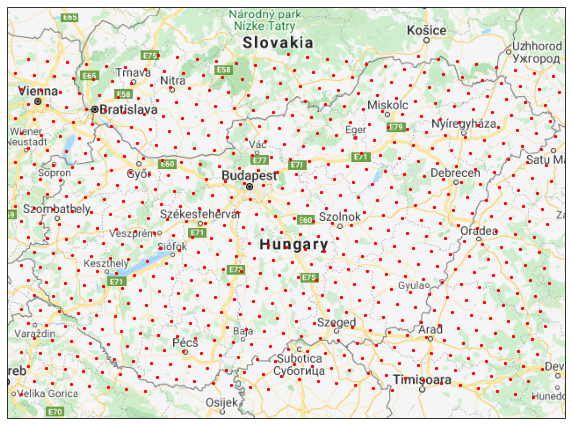

In [5]:
# https://stackoverflow.com/questions/50611018/cartopy-heatmap-over-openstreetmap-background
request = cimgt.GoogleTiles() # openstreetmap or google map background

# figure settings
fig, ax = plt.subplots(figsize=(10,18), subplot_kw=dict(projection=request.crs))
extent = [16, 23, 45.5, 49]  # (xmin, xmax, ymin, ymax) # select ROI
ax.set_extent(extent)
ax.add_image(request, 7) # 8 is a layer num, higher means more detail

# do coordinate conversion of (x,y), Geodetic is the default in set_extent()
xynps = ax.projection.transform_points( ccrs.Geodetic(), 
                                        boxids.lon.values[::1000], boxids.lat.values[::1000])
plt.scatter( xynps[:,0], xynps[:,1], s=5, marker='o', color='red' )

#### day graph loader

In [7]:
def create_day_graph_from_csv( path_to_file ):
    df = pd.read_csv( path_to_file, delimiter=',' )
    src_part = df.src.values
    dst_part = df.dst.values
    weight_part = []
    
    for i in range( df.shape[0] ):
        weight_part.append( '{\'weight\': '+str( np.round( df.traffic[i], 4 ) )[:7]+'}' )
    weight_part = np.array( weight_part )
    
    grap_to_parse = []
    for i in range( src_part.shape[0] ):
         grap_to_parse.append( str(src_part[i]) + ' ' + str( dst_part[i]) +' ' + weight_part[i] )
            
    G = nx.parse_edgelist( grap_to_parse , delimiter=' ', nodetype=int, create_using=nx.Graph())
    # graph node id based on cell id
    G_nodes_id = np.array( [i[0] for i in G.nodes(True) ] ).astype(int)
    G_nodes_df = pd.read_csv( source+'../'+'boxids_500.csv' ).iloc[ G_nodes_id ]
    G_nodes_df_header = list( G_nodes_df )
    G_nodes_id = G_nodes_df.values
    
    return G, G_nodes_df

In [8]:
source = '/mnt/processed_data/day_graphs_cleaned/'
#print(files_graphs[200])
g, g_nodes_df = create_day_graph_from_csv(source+'output_20190311.csv.gz')

##### Day graph's properties

In [9]:
len(g.nodes()), len(g.edges())

(102565, 549686)

#### Day graph

##### Whole country (experimental plot)

In [ ]:
graph_lon = boxids.iloc[list(g.nodes)].values[:,-1]
graph_lat = boxids.iloc[list(g.nodes)].values[:,-2]

pos_lonlat_nx = { j : ( graph_lon[i], 
                     graph_lat[i] ) for i, j in enumerate(list(g.nodes)) }

# do coordinate conversion of (x,y), Geodetic is the default in set_extent()
pos_geo = ax.projection.transform_points( ccrs.Geodetic(), 
                                        graph_lon, graph_lat)

pos_geo_nx = { j : ( pos_geo[i,0], 
                     pos_geo[i,1] ) for i, j in enumerate(list(g.nodes)) }


# Plot graph on map
request = cimgt.GoogleTiles() # openstreetmap or google map background

# figure settings
fig, ax = plt.subplots(figsize=(14,20), subplot_kw=dict(projection=request.crs))
extent = [16, 23, 45.5, 49]  # (xmin, xmax, ymin, ymax) # select ROI
ax.set_extent(extent)
ax.add_image(request, 7) # 7 is a layer num, higher means more detail

nx.draw(g, pos=pos_geo_nx, node_size=0.1, alpha=0.5, width=0.5)

##### Budapest (experimental plot)

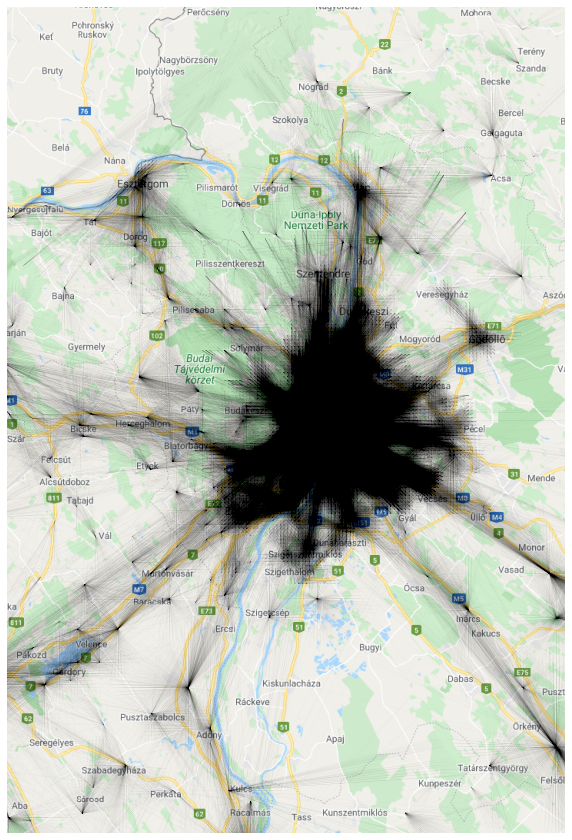

In [10]:
graph_lon = boxids.iloc[list(g.nodes)].values[:,-1]
graph_lat = boxids.iloc[list(g.nodes)].values[:,-2]

pos_lonlat_nx = { j : ( graph_lon[i], 
                     graph_lat[i] ) for i, j in enumerate(list(g.nodes)) }

# do coordinate conversion of (x,y), Geodetic is the default in set_extent()
pos_geo = ax.projection.transform_points( ccrs.Geodetic(), 
                                        graph_lon, graph_lat)

pos_geo_nx = { j : ( pos_geo[i,0], 
                     pos_geo[i,1] ) for i, j in enumerate(list(g.nodes)) }

# Plot graph on map
request = cimgt.GoogleTiles() # openstreetmap or google map background

# figure settings
fig, ax = plt.subplots(figsize=(10,18), subplot_kw=dict(projection=request.crs))
extent = [18.5, 19.5, 47, 48]  # (xmin, xmax, ymin, ymax) # select ROI
ax.set_extent(extent)
ax.add_image(request, 10) # the num is a layer num, higher means more detail

nx.draw(g, pos=pos_geo_nx, node_size=0.0001, alpha=0.1, width=0.1)

#### Short time interval graphs (5 min) with 0.25 threshold

In [11]:
source = '/mnt/processed_data/5min_graphs_cleaned_threshold-025_boxside-500/'

#### Graph properties

In [12]:
num_to_load = 70
print(files_graphs[num_to_load])
g, g_nodes_df = create_day_graph_from_csv(source+files_graphs[num_to_load])
len(g.nodes()), len(g.edges())

output_20181202-1600-1605


(7193, 17193)

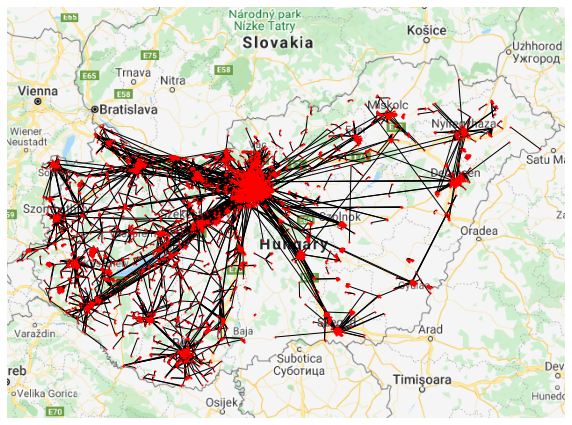

In [13]:
graph_lon = boxids.iloc[list(g.nodes)].values[:,-1]
graph_lat = boxids.iloc[list(g.nodes)].values[:,-2]

pos_lonlat_nx = { j : ( graph_lon[i], 
                     graph_lat[i] ) for i, j in enumerate(list(g.nodes)) }

# do coordinate conversion of (x,y), Geodetic is the default in set_extent()
pos_geo = ax.projection.transform_points( ccrs.Geodetic(), 
                                        graph_lon, graph_lat)

pos_geo_nx = { j : ( pos_geo[i,0], 
                     pos_geo[i,1] ) for i, j in enumerate(list(g.nodes)) }

# Plot graph on map
request = cimgt.GoogleTiles() # openstreetmap or google map background

# figure settings
fig, ax = plt.subplots(figsize=(10,18), subplot_kw=dict(projection=request.crs))
extent = [16, 23, 45.5, 49]  # (xmin, xmax, ymin, ymax) # select ROI
ax.set_extent(extent)
ax.add_image(request, 7) # the num is a layer num, higher means more detail

nx.draw(g, pos=pos_geo_nx, node_size=1, alpha=1, node_color='red')

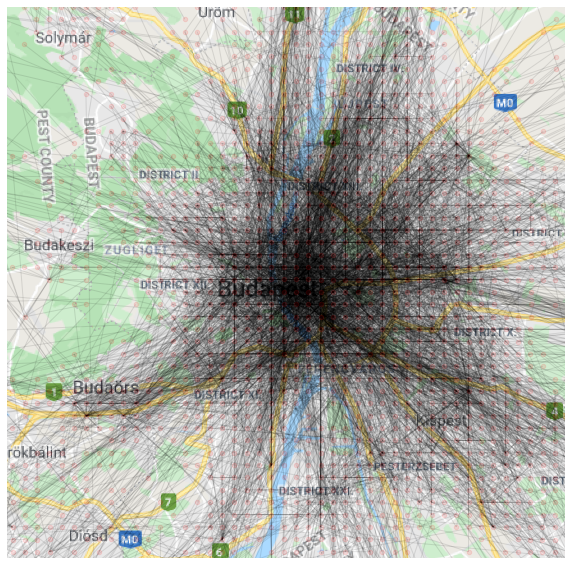

In [57]:
graph_lon = boxids.iloc[list(g.nodes)].values[:,-1]
graph_lat = boxids.iloc[list(g.nodes)].values[:,-2]

pos_lonlat_nx = { j : ( graph_lon[i], 
                     graph_lat[i] ) for i, j in enumerate(list(g.nodes)) }

# do coordinate conversion of (x,y), Geodetic is the default in set_extent()
pos_geo = ax.projection.transform_points( ccrs.Geodetic(), 
                                        graph_lon, graph_lat)

pos_geo_nx = { j : ( pos_geo[i,0], 
                     pos_geo[i,1] ) for i, j in enumerate(list(g.nodes)) }

# Plot graph on map
request = cimgt.GoogleTiles() # openstreetmap or google map background

# figure settings
fig, ax = plt.subplots(figsize=(10,18), subplot_kw=dict(projection=request.crs))
extent = [18.9, 19.2, 47.4, 47.6]  # (xmin, xmax, ymin, ymax) # select ROI
ax.set_extent(extent)
ax.add_image(request, 11) # the num is a layer num, higher means more detail

nx.draw(g, pos=pos_geo_nx, node_size=20, alpha=0.1, node_color='red')

In [58]:
cells_df = pd.read_csv( source+files_cells[num_to_load] )
cells_df.head()

id     total  total_speed        ne   ne_speed        nw   nw_speed  \
0  344048  0.875078    29.955368  0.022227  43.798237  0.347552  44.640427   
1  258610  0.265620    33.070473  0.023036  30.028164  0.076032   5.489308   
2  398407  0.256240    16.574223  0.000000        NaN  0.187766  16.174503   
3  301323  0.618579    54.037450  0.097693  65.492180  0.268376  25.174858   
4   49006  1.052578     9.862704  0.359649   2.567498  0.503461  17.783884   

         sw   sw_speed        se   se_speed  
0  0.050678  47.469610  0.454622  16.099741  
1  0.057359  26.558874  0.109193  56.337963  
2  0.000000        NaN  0.068474  17.670300  
3  0.022732  55.390790  0.229778  82.744400  
4  0.145261   0.626459  0.044207   9.350979

In [59]:
cells_df.shape, cells_df.total.sum()

((13450, 11), 24665.04442759)

In [60]:
cells_df_lonlat =  pd.merge( left=boxids.iloc[ cells_df.id.values ], right=cells_df, 
          left_on='boxid', right_on='id').drop('id', axis=1)
cells_df_lonlat.head()

boxid    eovx    eovy        lat        lon     total  total_speed  \
0  344048  177194  695591  46.937404  19.646238  0.875078    29.955368   
1  258610  271194  628591  47.784149  18.761743  0.265620    33.070473   
2  398407  199194  738091  47.130998  20.208651  0.256240    16.574223   
3  301323  221194  662091  47.334663  19.207435  0.618579    54.037450   
4   49006  265194  464591  47.704158  16.576551  1.052578     9.862704   

         ne   ne_speed        nw   nw_speed        sw   sw_speed        se  \
0  0.022227  43.798237  0.347552  44.640427  0.050678  47.469610  0.454622   
1  0.023036  30.028164  0.076032   5.489308  0.057359  26.558874  0.109193   
2  0.000000        NaN  0.187766  16.174503  0.000000        NaN  0.068474   
3  0.097693  65.492180  0.268376  25.174858  0.022732  55.390790  0.229778   
4  0.359649   2.567498  0.503461  17.783884  0.145261   0.626459  0.044207   

    se_speed  
0  16.099741  
1  56.337963  
2  17.670300  
3  82.744400  
4   9.350979

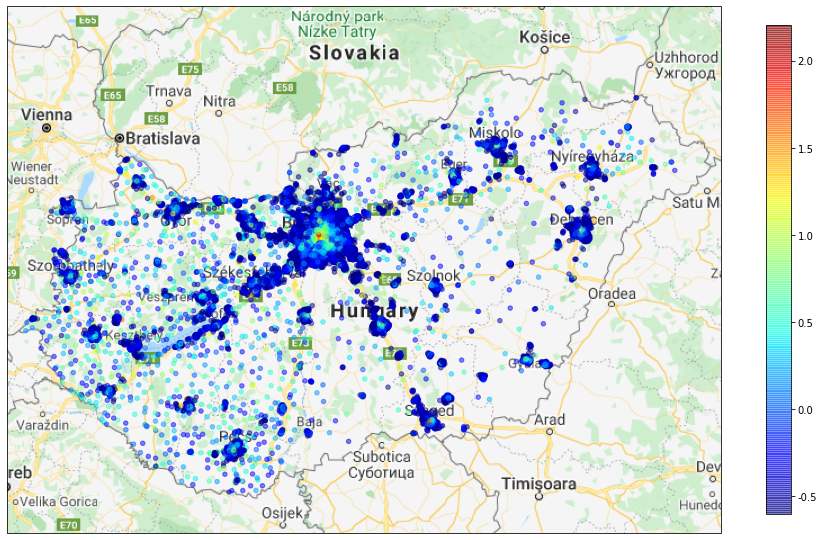

In [61]:
cells_lon = cells_df_lonlat.lon.values
cells_lat = cells_df_lonlat.lat.values

# https://stackoverflow.com/questions/50611018/cartopy-heatmap-over-openstreetmap-background
request = cimgt.GoogleTiles() # openstreetmap or google map background

# figure settings
fig, ax = plt.subplots(figsize=(16,20), subplot_kw=dict(projection=request.crs))
extent = [16, 23, 45.5, 49]  # (xmin, xmax, ymin, ymax) # select ROI
ax.set_extent(extent)
ax.add_image(request, 7) # 8 is a layer num, higher means more detail

# do coordinate conversion of (x,y), Geodetic is the default in set_extent()
xynps = ax.projection.transform_points( ccrs.Geodetic(), 
                                        cells_lon, cells_lat)
cbar = plt.scatter( xynps[:,0], xynps[:,1], c=np.log10(cells_df_lonlat.total.values), 
                    s=20, marker='o', cmap='jet', alpha=0.5 )
plt.colorbar(cbar, shrink=0.45, format='%.1f')

#### 5 min interval graph but threshold 0

In [63]:
source = '/mnt/processed_data/5min_graphs_cleaned_threshold-0_boxside-500/'
print('output_20181201-1000-1005')
g, g_nodes_df = create_day_graph_from_csv(source+'output_20181201-1000-1005')
len(g.nodes()), len(g.edges())

output_20181201-1000-1005


(91629, 132264)

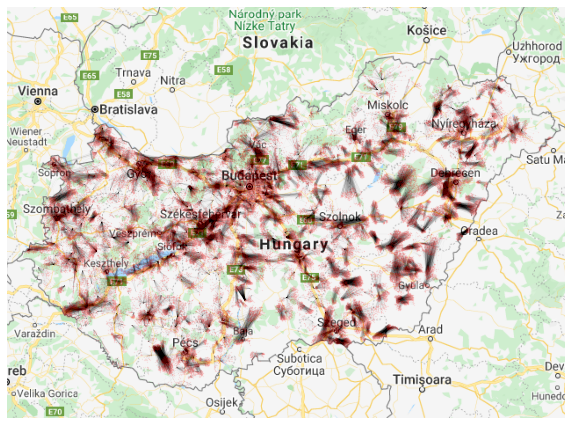

In [64]:
graph_lon = boxids.iloc[list(g.nodes)].values[:,-1]
graph_lat = boxids.iloc[list(g.nodes)].values[:,-2]

pos_lonlat_nx = { j : ( graph_lon[i], 
                     graph_lat[i] ) for i, j in enumerate(list(g.nodes)) }

# do coordinate conversion of (x,y), Geodetic is the default in set_extent()
pos_geo = ax.projection.transform_points( ccrs.Geodetic(), 
                                        graph_lon, graph_lat)

pos_geo_nx = { j : ( pos_geo[i,0], 
                     pos_geo[i,1] ) for i, j in enumerate(list(g.nodes)) }

# Plot graph on map
request = cimgt.GoogleTiles() # openstreetmap or google map background

# figure settings
fig, ax = plt.subplots(figsize=(10,18), subplot_kw=dict(projection=request.crs))
extent = [16, 23, 45.5, 49]  # (xmin, xmax, ymin, ymax) # select ROI
ax.set_extent(extent)
ax.add_image(request, 7) # the num is a layer num, higher means more detail

nx.draw(g, pos=pos_geo_nx, node_size=0.1, alpha=0.1, node_color='red', width=0.1)

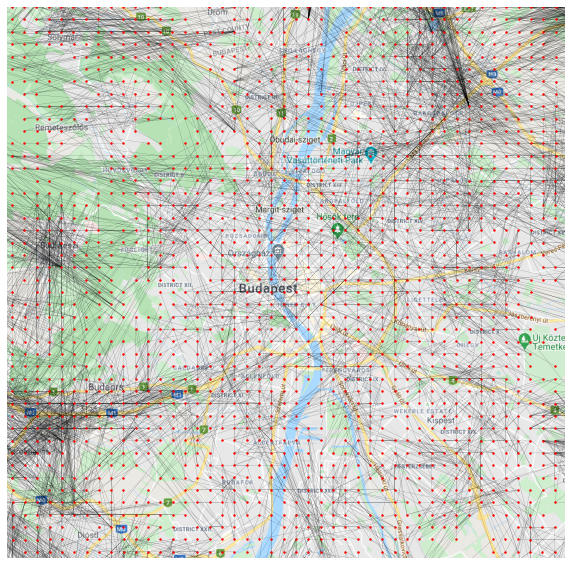

In [65]:
graph_lon = boxids.iloc[list(g.nodes)].values[:,-1]
graph_lat = boxids.iloc[list(g.nodes)].values[:,-2]

pos_lonlat_nx = { j : ( graph_lon[i], 
                     graph_lat[i] ) for i, j in enumerate(list(g.nodes)) }

# do coordinate conversion of (x,y), Geodetic is the default in set_extent()
pos_geo = ax.projection.transform_points( ccrs.Geodetic(), 
                                        graph_lon, graph_lat)

pos_geo_nx = { j : ( pos_geo[i,0], 
                     pos_geo[i,1] ) for i, j in enumerate(list(g.nodes)) }

# Plot graph on map
request = cimgt.GoogleTiles() # openstreetmap or google map background

# figure settings
fig, ax = plt.subplots(figsize=(10,18), subplot_kw=dict(projection=request.crs))
extent = [18.9, 19.2, 47.4, 47.6]  # (xmin, xmax, ymin, ymax) # select ROI
ax.set_extent(extent)
ax.add_image(request, 12) # the num is a layer num, higher means more detail

nx.draw(g, pos=pos_geo_nx, node_size=2, alpha=1, width=0.1, node_color='red')

In [66]:
cells_df = pd.read_csv( source+'output_20181201-1000-1005-cells' )
cells_df_lonlat =  pd.merge( left=boxids.iloc[ cells_df.id.values ], right=cells_df, 
          left_on='boxid', right_on='id').drop('id', axis=1)

In [67]:
cells_df.shape

(30822, 11)

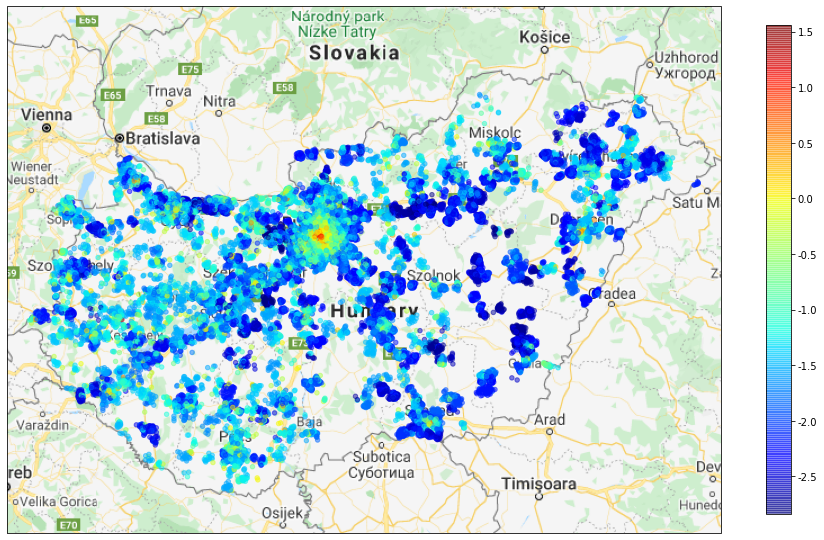

In [68]:
cells_lon = cells_df_lonlat.lon.values
cells_lat = cells_df_lonlat.lat.values

# https://stackoverflow.com/questions/50611018/cartopy-heatmap-over-openstreetmap-background
request = cimgt.GoogleTiles() # openstreetmap or google map background

# figure settings
fig, ax = plt.subplots(figsize=(16,20), subplot_kw=dict(projection=request.crs))
extent = [16, 23, 45.5, 49]  # (xmin, xmax, ymin, ymax) # select ROI
ax.set_extent(extent)
ax.add_image(request, 7) # 8 is a layer num, higher means more detail

# do coordinate conversion of (x,y), Geodetic is the default in set_extent()
xynps = ax.projection.transform_points( ccrs.Geodetic(), 
                                        cells_lon, cells_lat)
cbar = plt.scatter( xynps[:,0], xynps[:,1], c=np.log10(cells_df_lonlat.total.values), 
                    s=20, marker='o', cmap='jet', alpha=0.5 )
plt.colorbar(cbar, shrink=0.45, format='%.1f')

### Load equipments data

In [16]:
boxids.head()

boxid   eovx    eovy        lat        lon
0      0  44194  426591  45.705620  16.178645
1      1  44694  426591  45.710115  16.178409
2      2  45194  426591  45.714610  16.178173
3      3  45694  426591  45.719104  16.177938
4      4  46194  426591  45.723599  16.177702

In [3]:
eq_df = pd.read_csv( '/mnt2/data/csv/EqNum_20190528.csv', delimiter=';' )
eq_df.shape

(37878798, 4)

In [ ]:
box

In [14]:
eq_df.x.values, eq_df.y.values

(array([100194, 100194, 100194, ...,  99694,  99694,  99694]),
 array([492591, 492591, 492591, ..., 792591, 793091, 793091]))

In [37]:
eq_df[(eq_df.eqNum.values > 10)]

x       y  time  eqNum
1225      100194  499591   525     14
1226      100194  499591   530     12
1227      100194  499591   535     14
1228      100194  499591   540     17
1229      100194  499591   545     18
...          ...     ...   ...    ...
37876213   99694  765591  2325     22
37876214   99694  765591  2330     22
37876215   99694  765591  2335     21
37876216   99694  765591  2340     17
37876217   99694  765591  2345     14

[4129675 rows x 4 columns]

In [18]:
eq_df.x.values[0]

100194

In [30]:
idx_lonlat = []
for i in tqdm( range(eq_df.x.values.shape[0]) ):
    idx_lonlat.append( np.argwhere( np.logical_and(
            eq_df.x.values[i] == boxids.eovx.values, 
            eq_df.y.values[i] == boxids.eovy.values) )[0][0] ) 

  0%|          | 20836/37878798 [00:20<10:34:59, 993.65it/s] 


KeyboardInterrupt: 

In [5]:
eq_df.eqNum.sum()

359114156

(array([3.6327681e+07, 7.4600000e+05, 2.6925900e+05, 1.3490200e+05,
        8.7614000e+04, 5.6838000e+04, 4.4001000e+04, 3.1250000e+04,
        2.4830000e+04, 1.9522000e+04, 1.7253000e+04, 1.3997000e+04,
        1.1473000e+04, 1.0205000e+04, 8.1380000e+03, 7.1780000e+03,
        5.9830000e+03, 5.3900000e+03, 4.5010000e+03, 3.9340000e+03,
        3.2000000e+03, 3.0430000e+03, 2.7650000e+03, 2.5730000e+03,
        2.2910000e+03, 1.9280000e+03, 1.6630000e+03, 1.5860000e+03,
        1.5460000e+03, 1.4380000e+03, 1.3390000e+03, 1.2260000e+03,
        1.0150000e+03, 9.7600000e+02, 8.8600000e+02, 9.2600000e+02,
        9.1200000e+02, 9.2000000e+02, 8.9700000e+02, 8.5900000e+02,
        7.8200000e+02, 7.4600000e+02, 6.6400000e+02, 6.7600000e+02,
        5.5300000e+02, 5.3300000e+02, 5.3000000e+02, 4.8500000e+02,
        3.9600000e+02, 4.6000000e+02, 3.8800000e+02, 3.9200000e+02,
        3.4100000e+02, 2.8100000e+02, 3.1300000e+02, 3.1800000e+02,
        3.0100000e+02, 2.7800000e+02, 2.0300000e

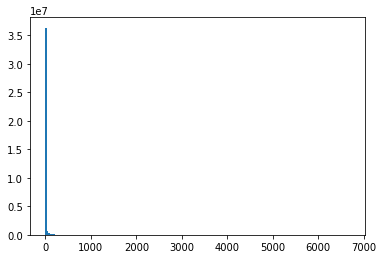

In [7]:
plt.hist(eq_df.eqNum.values, bins=200)

In [69]:
len(list(g.edges()))

132264

In [77]:
from graph_tool.all import *

In [78]:
def get_prop_type(value, key=None):
    """
    Performs typing and value conversion for the graph_tool PropertyMap class.
    If a key is provided, it also ensures the key is in a format that can be
    used with the PropertyMap. Returns a tuple, (type name, value, key)
    """
    if isinstance(key, str):
        # Encode the key as utf-8
        key = key.encode('utf-8', errors='replace')

    # Deal with the value
    if isinstance(value, bool):
        tname = 'bool'

    elif isinstance(value, int):
        tname = 'float'
        value = float(value)

    elif isinstance(value, float):
        tname = 'float'

    elif isinstance(value, str):
        tname = 'string'
        value = value.encode('utf-8', errors='replace')

    elif isinstance(value, dict):
        tname = 'object'

    else:
        tname = 'string'
        value = str(value)
        
    #If key is a byte value, decode it to string
    try:
        key = key.decode('utf-8')
    except AttributeError:
        pass

    return tname, value, key


def nx2gt(nxG):
    """
    Converts a networkx graph to a graph-tool graph.
    """
    # Phase 0: Create a directed or undirected graph-tool Graph
    gtG = Graph(directed=nxG.is_directed())

    # Add the Graph properties as "internal properties"
    for key, value in list(nxG.graph.items()):
        # Convert the value and key into a type for graph-tool
        tname, value, key = get_prop_type(value, key)

        prop = gtG.new_graph_property(tname) # Create the PropertyMap
        
        gtG.graph_properties[key] = prop     # Set the PropertyMap
        gtG.graph_properties[key] = value    # Set the actual value

    # Phase 1: Add the vertex and edge property maps
    # Go through all nodes and edges and add seen properties
    # Add the node properties first
    nprops = set() # cache keys to only add properties once
    for node, data in nxG.nodes(data=True):

        # Go through all the properties if not seen and add them.
        for key, val in list(data.items()):            
            if key in nprops: continue # Skip properties already added

            # Convert the value and key into a type for graph-tool
            tname, _, key  = get_prop_type(val, key)

            prop = gtG.new_vertex_property(tname) # Create the PropertyMap
            gtG.vertex_properties[key] = prop     # Set the PropertyMap

            # Add the key to the already seen properties
            nprops.add(key)

    # Also add the node id: in NetworkX a node can be any hashable type, but
    # in graph-tool node are defined as indices. So we capture any strings
    # in a special PropertyMap called 'id' -- modify as needed!
    gtG.vertex_properties['id'] = gtG.new_vertex_property('string')

    # Add the edge properties second
    eprops = set() # cache keys to only add properties once
    for src, dst, data in nxG.edges(data=True):

        # Go through all the edge properties if not seen and add them.
        for key, val in list(data.items()):            
            if key in eprops: continue # Skip properties already added

            # Convert the value and key into a type for graph-tool
            tname, _, key = get_prop_type(val, key)
            
            prop = gtG.new_edge_property(tname) # Create the PropertyMap
            gtG.edge_properties[key] = prop     # Set the PropertyMap

            # Add the key to the already seen properties
            eprops.add(key)

    # Phase 2: Actually add all the nodes and vertices with their properties
    # Add the nodes
    vertices = {} # vertex mapping for tracking edges later
    for node, data in nxG.nodes(data=True):

        # Create the vertex and annotate for our edges later
        v = gtG.add_vertex()
        vertices[node] = v

        # Set the vertex properties, not forgetting the id property
        data['id'] = str(node)
        for key, value in list(data.items()):
            gtG.vp[key][v] = value # vp is short for vertex_properties

    # Add the edges
    for src, dst, data in nxG.edges(data=True):

        # Look up the vertex structs from our vertices mapping and add edge.
        e = gtG.add_edge(vertices[src], vertices[dst])

        # Add the edge properties
        for key, value in list(data.items()):
            gtG.ep[key][e] = value # ep is short for edge_properties

    # Done, finally!
    return gtG

In [79]:
gtG = nx2gt(g)

(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1938.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29

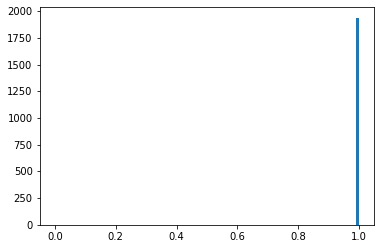

In [80]:
plt.hist( np.array( list( gtG._Graph__edge_properties['weight'] ) ), bins=np.linspace(0,1,101) )

In [83]:
np.min( list( gtG._Graph__edge_properties['weight'] ) ), np.max( list( gtG._Graph__edge_properties['weight'] ) )

(1.0, 5838.83)

#### Other methods

Source: 
- https://www.analyticsvidhya.com/blog/2020/06/guide-geospatial-analysis-folium-python/
- https://towardsdatascience.com/level-up-your-visualizations-make-interactive-maps-with-python-and-bokeh-7a8c1da911fd